In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
from scipy.integrate import quad

C:\Users\lopezb41\AppData\Local\Temp\ipykernel_9456\1721861455.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(dpi = 100)


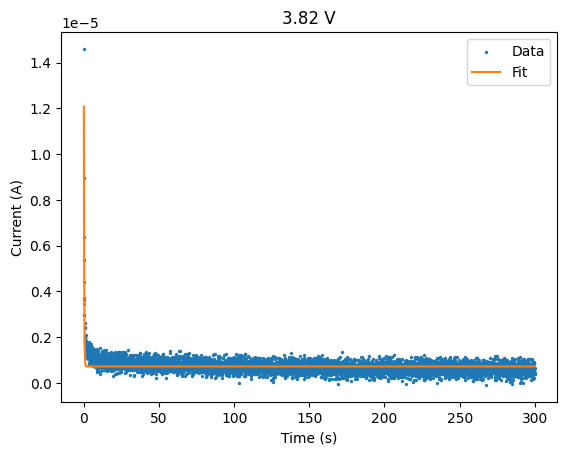

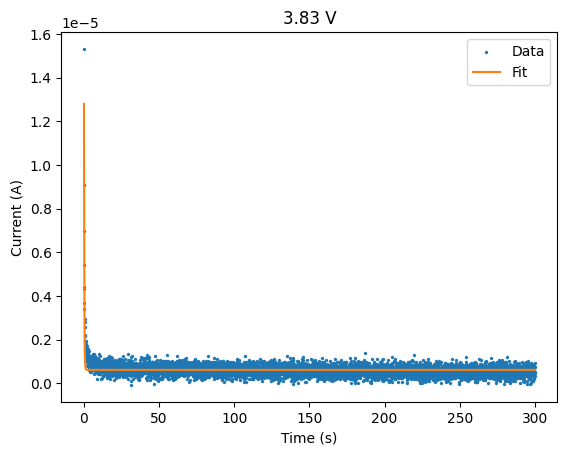

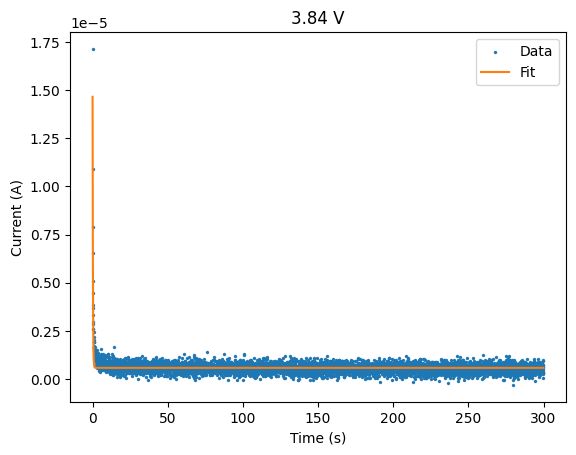

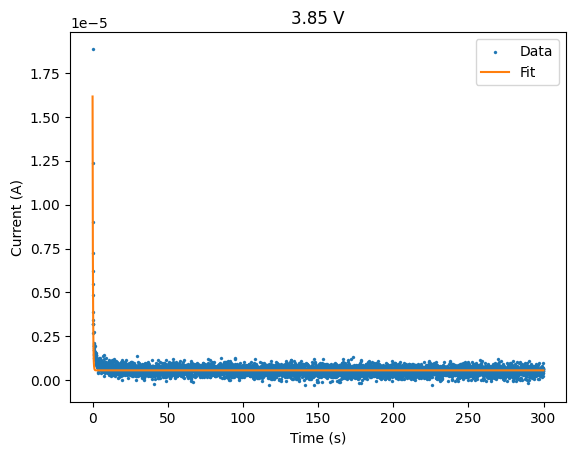

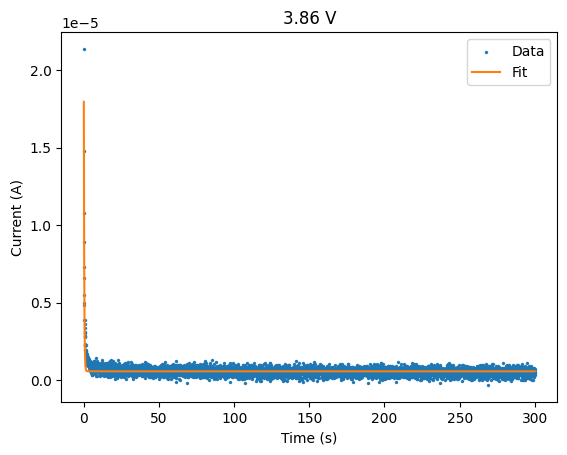

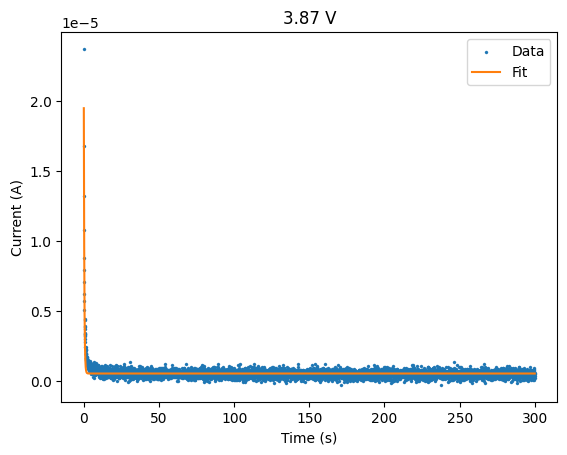

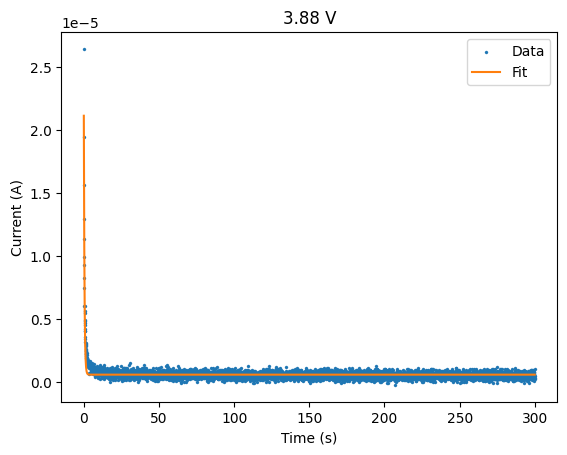

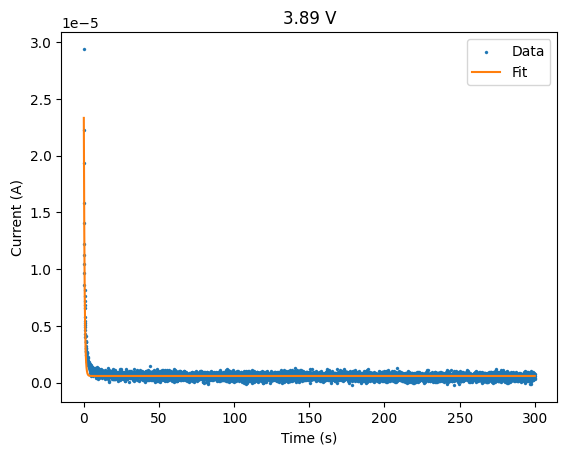

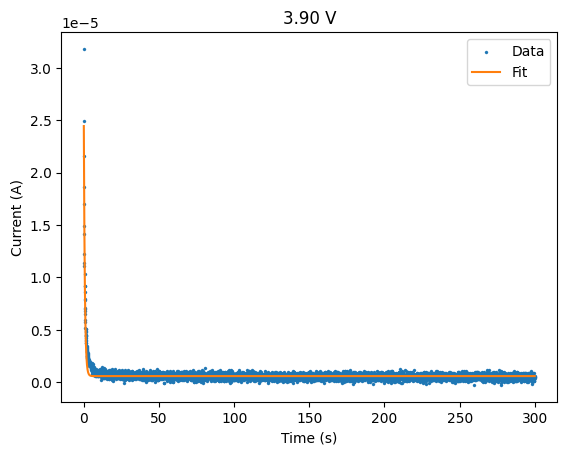

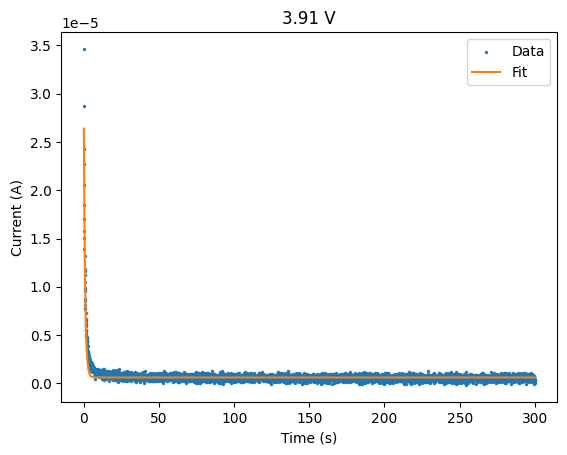

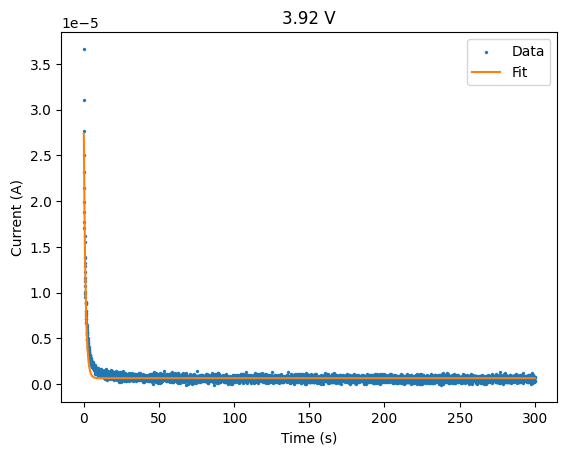

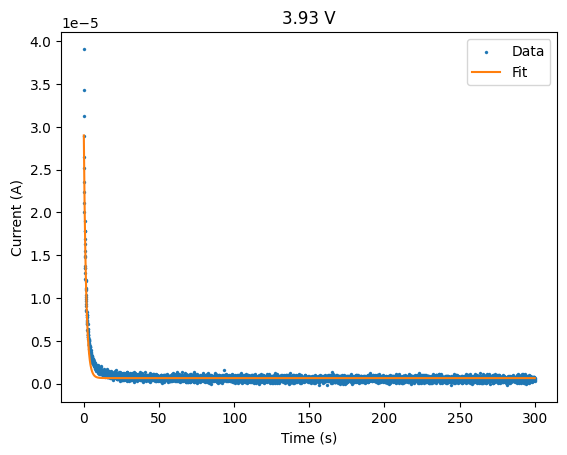

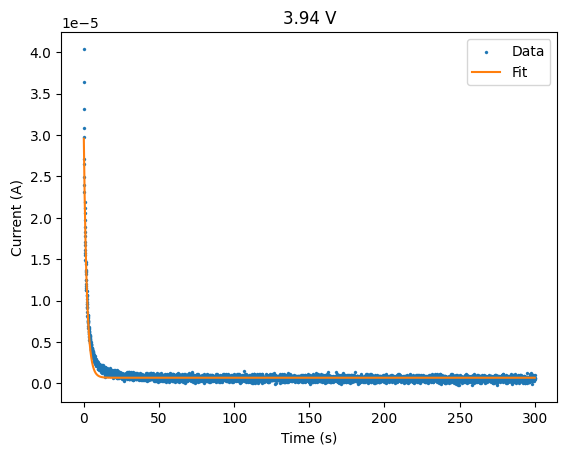

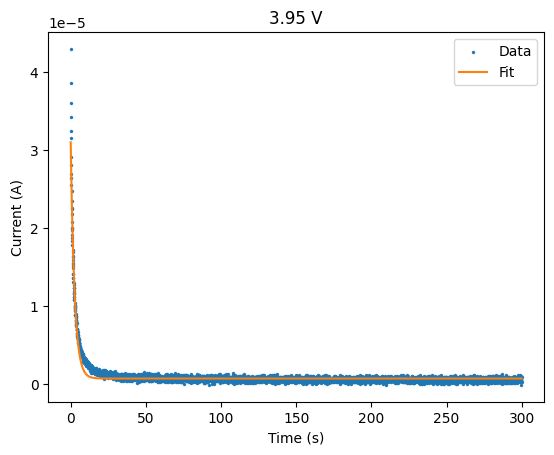

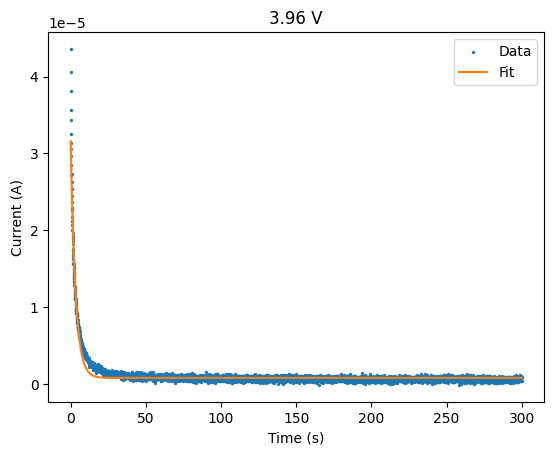

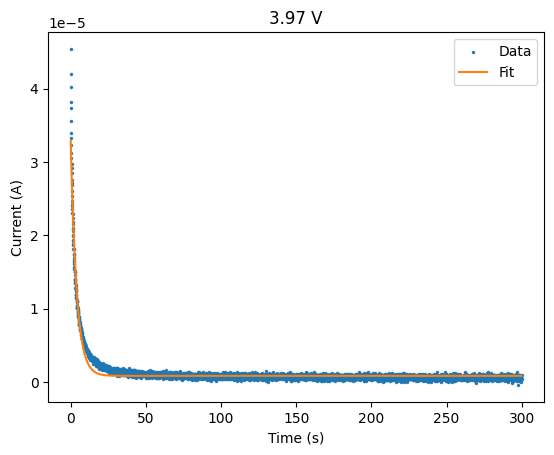

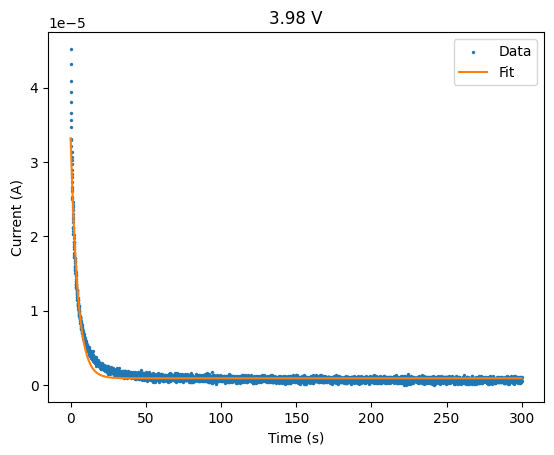

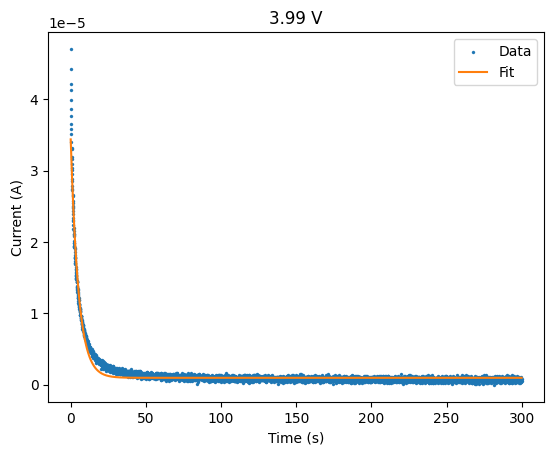

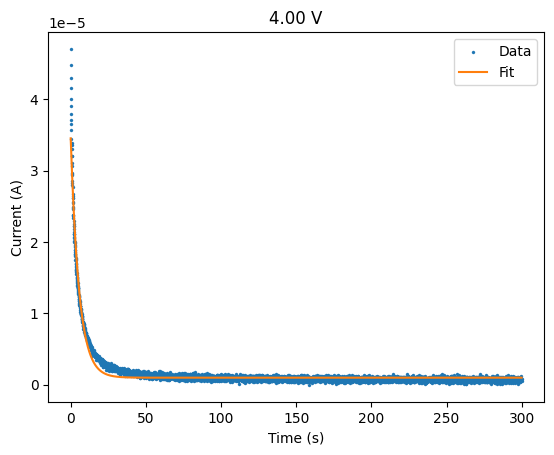

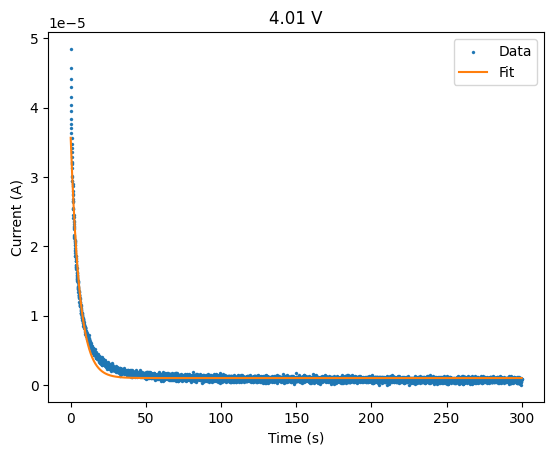

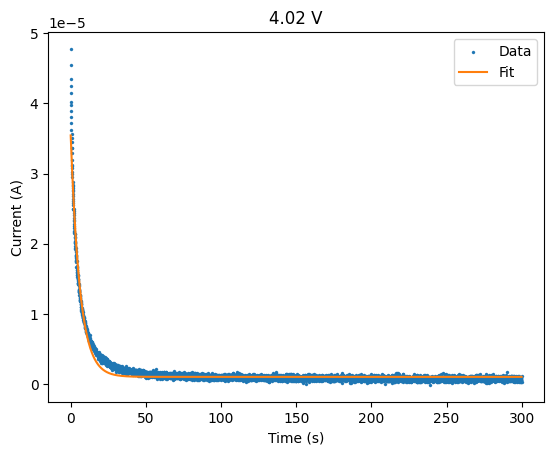

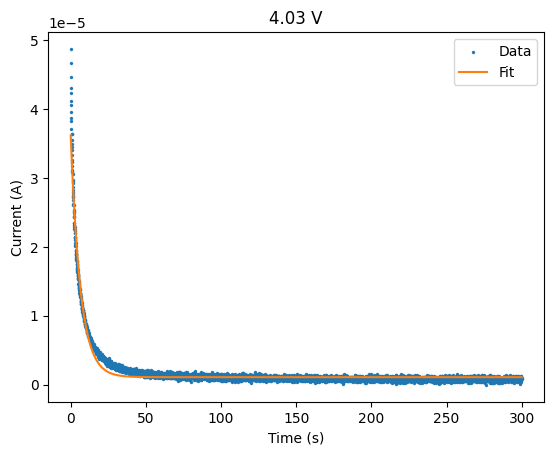

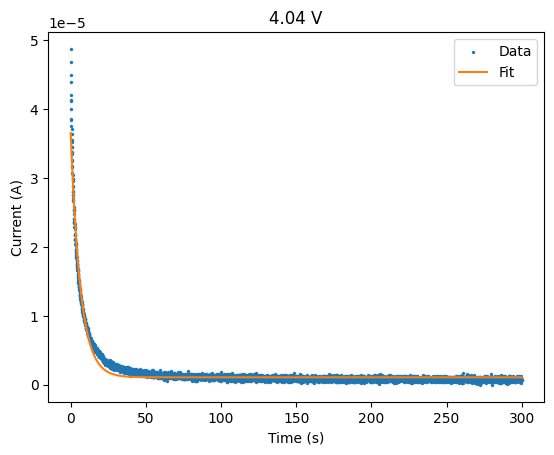

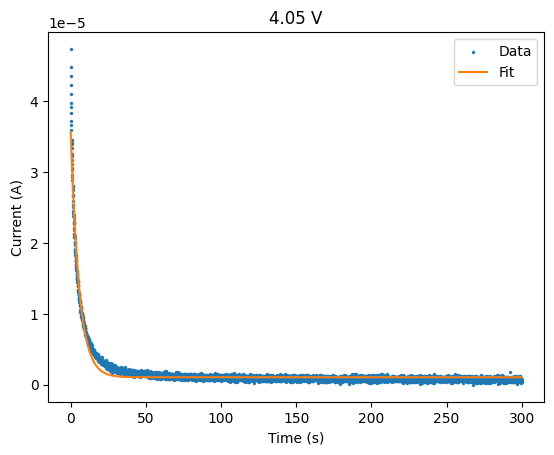

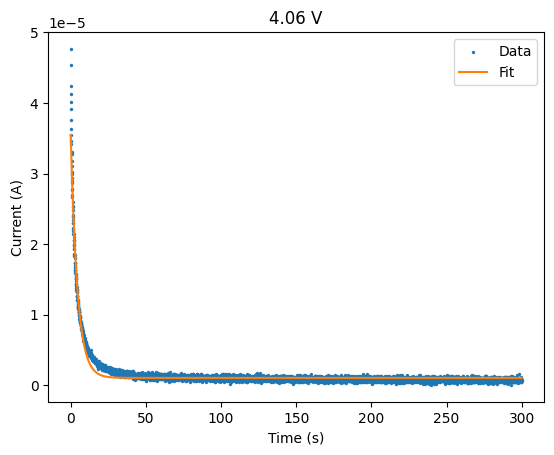

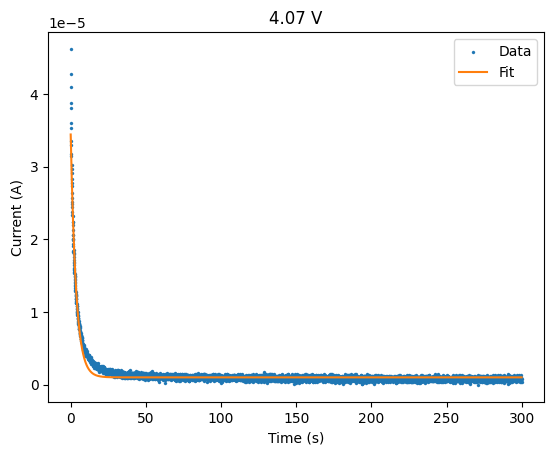

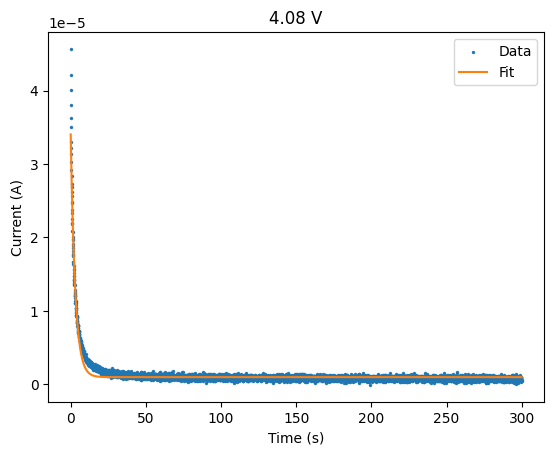

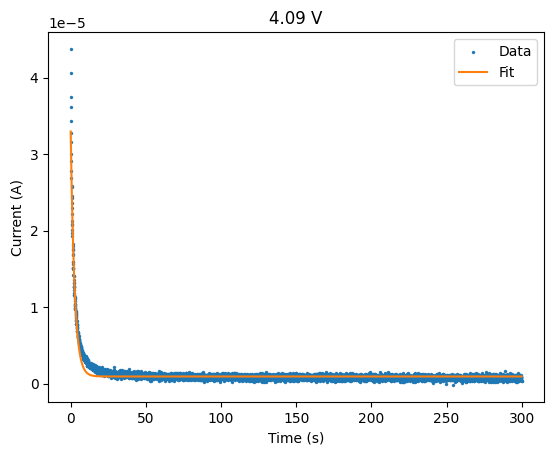

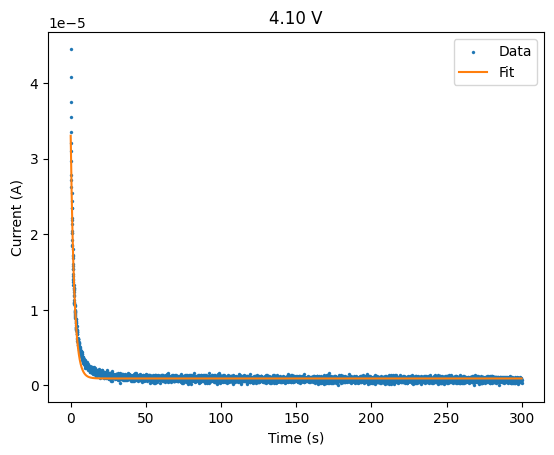

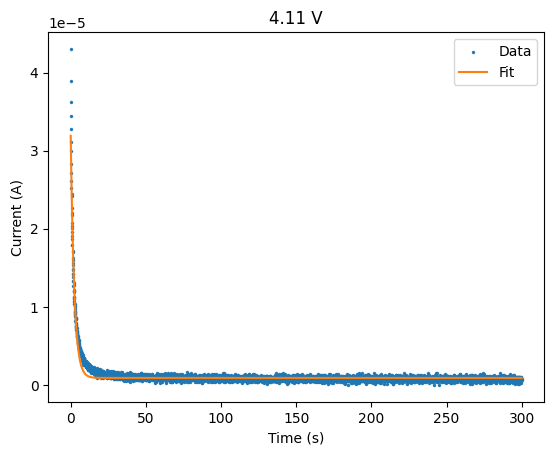

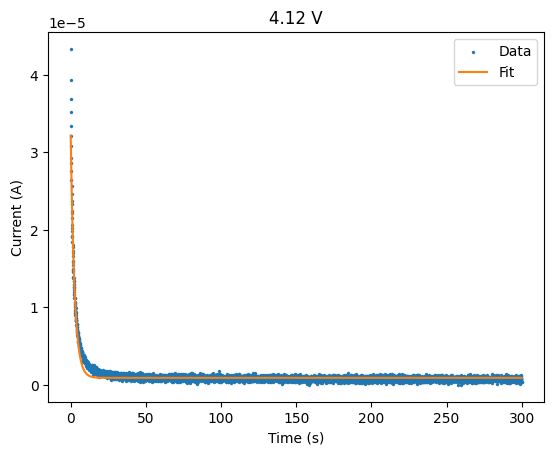

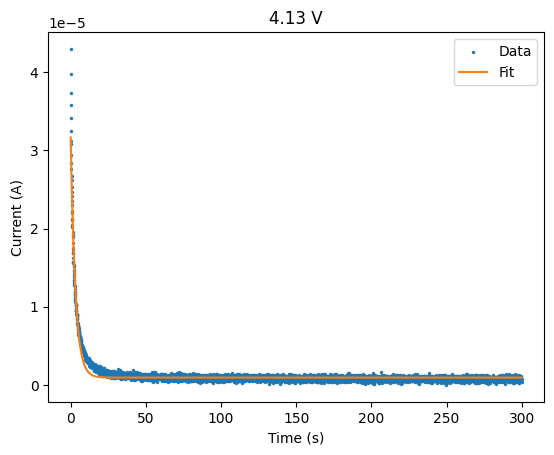

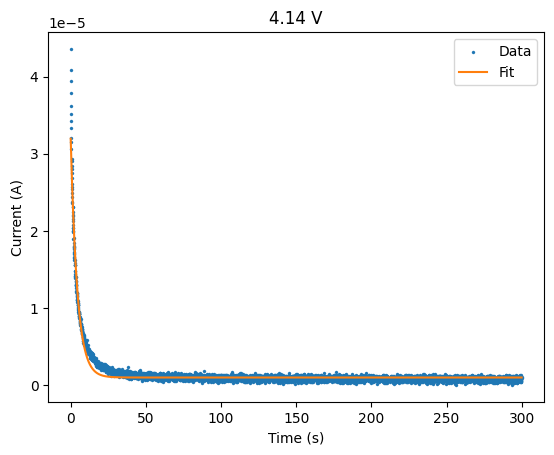

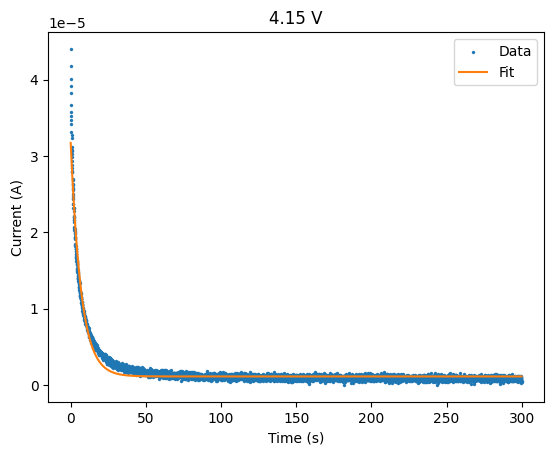

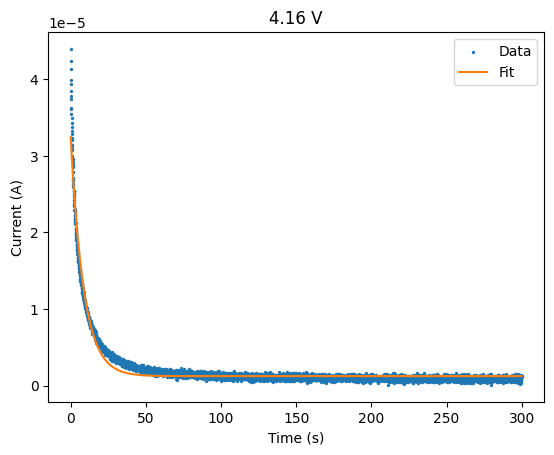

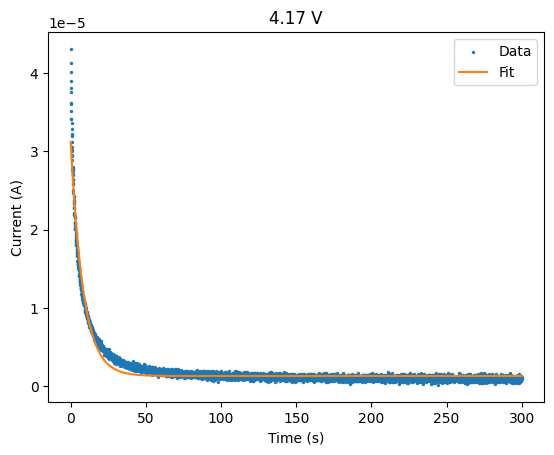

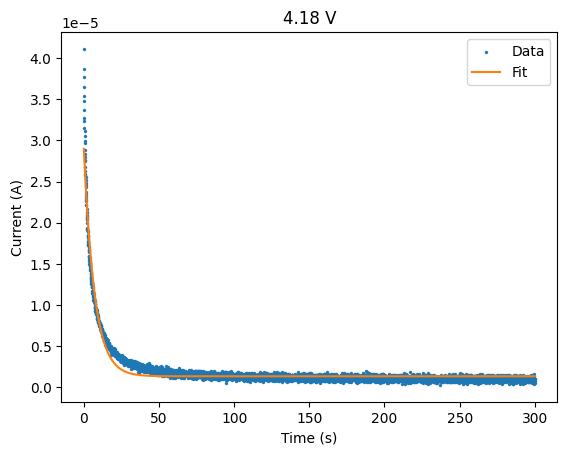

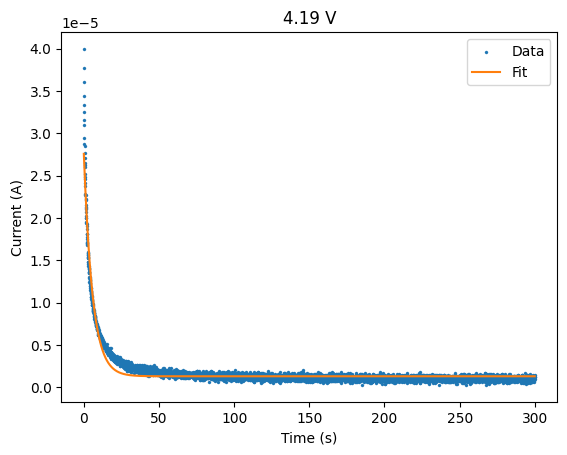

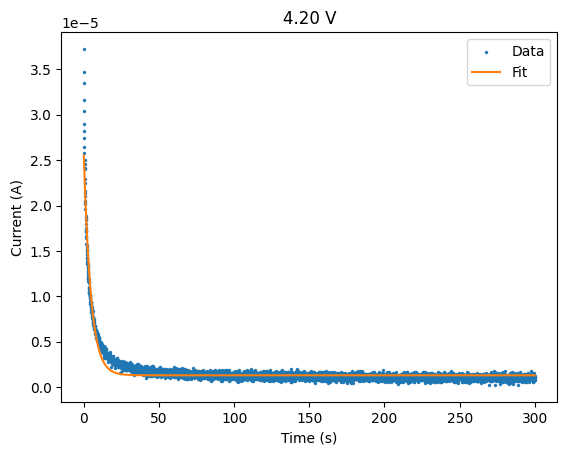

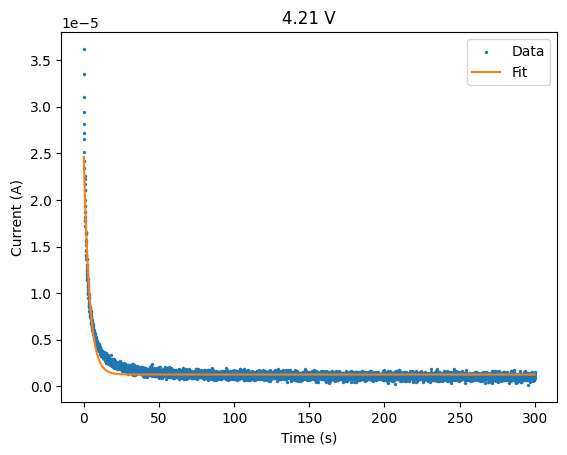

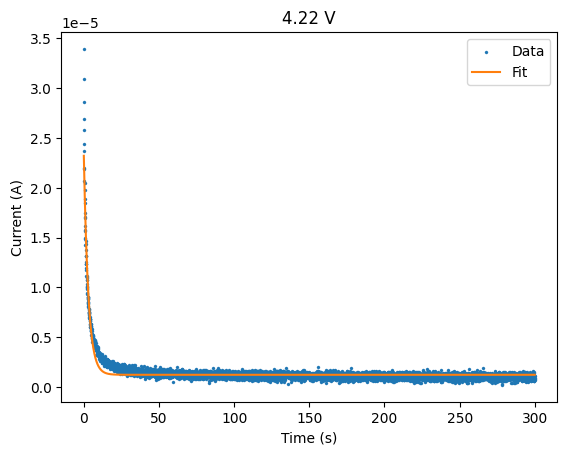

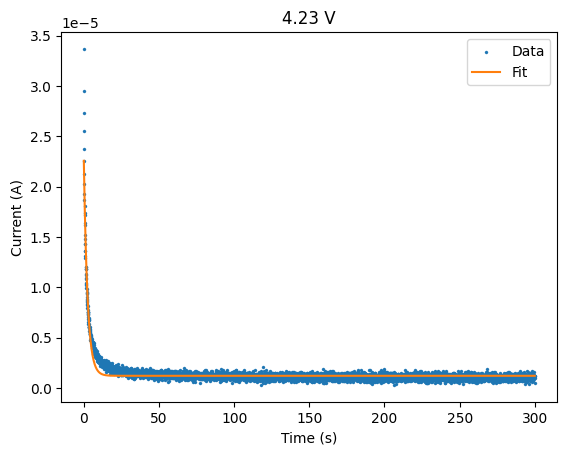

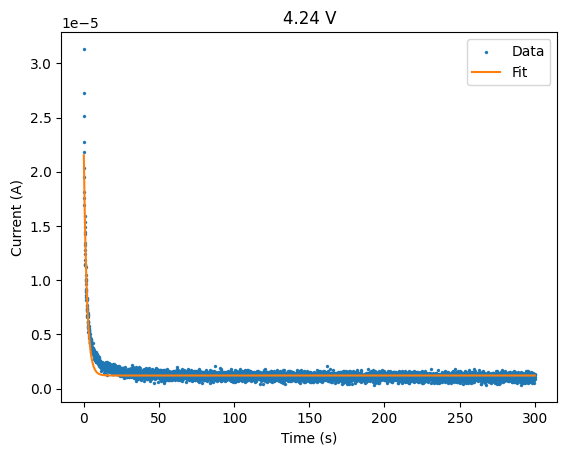

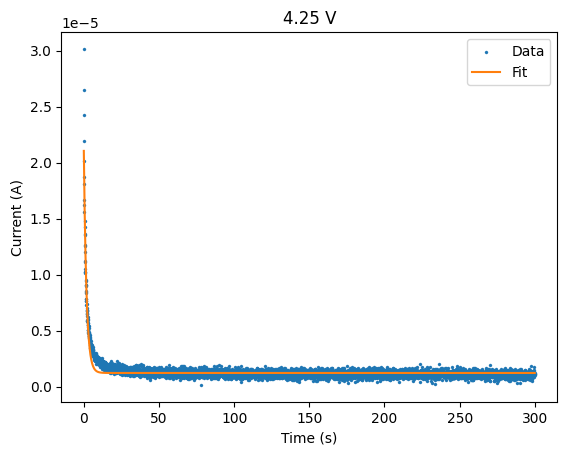

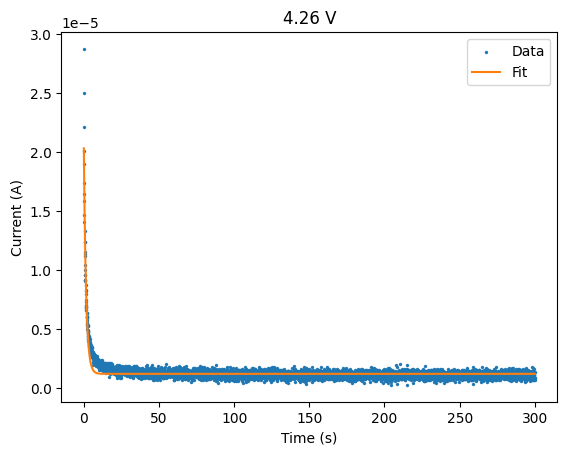

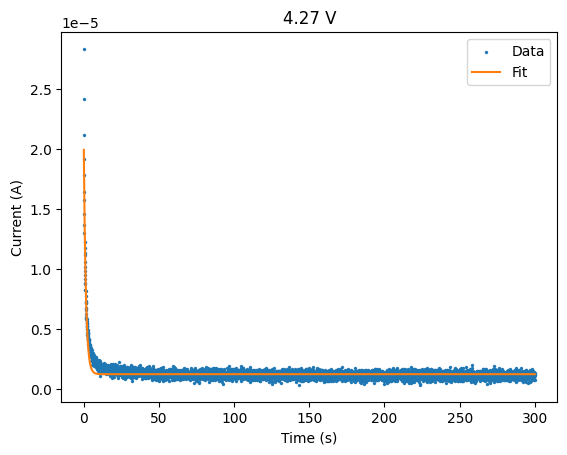

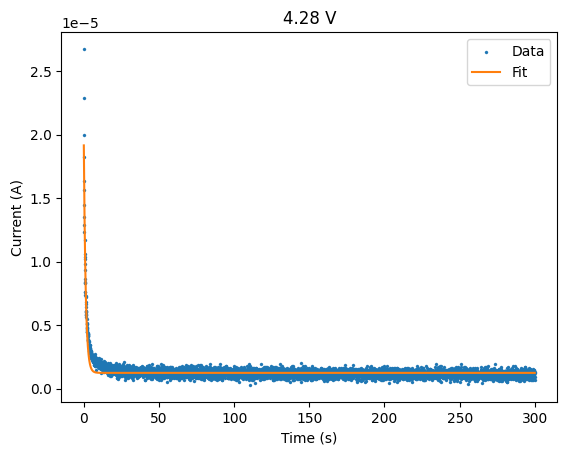

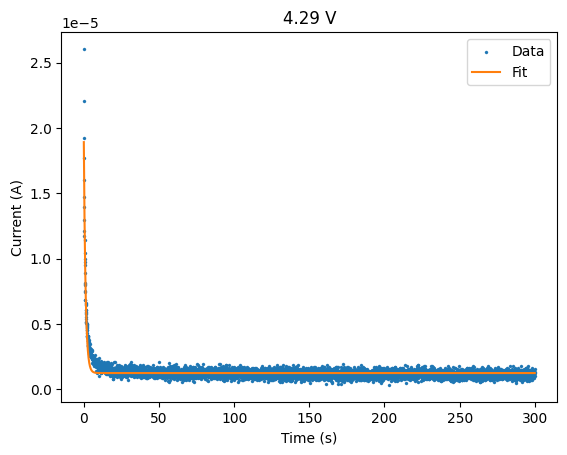

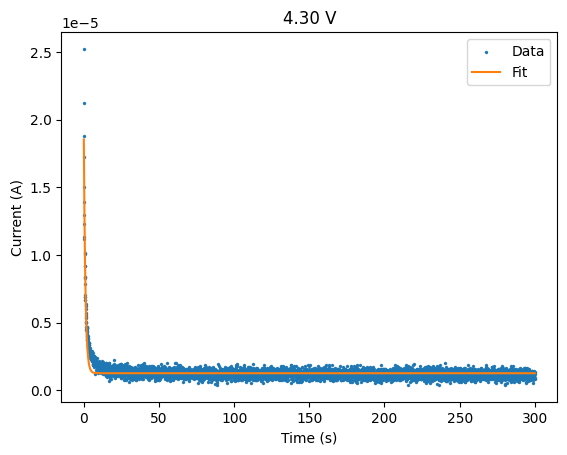

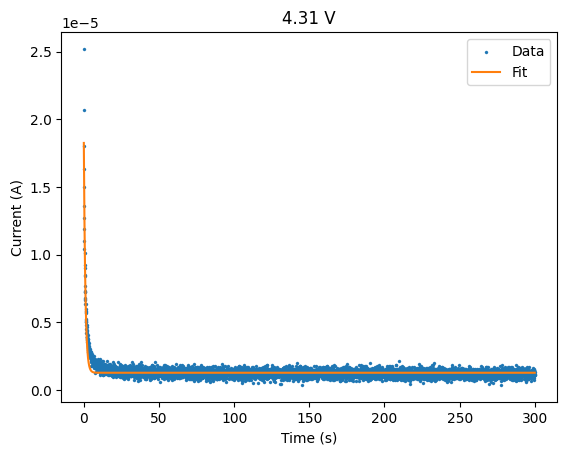

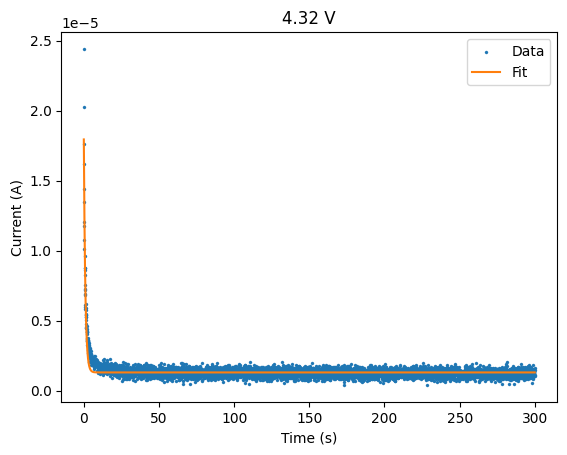

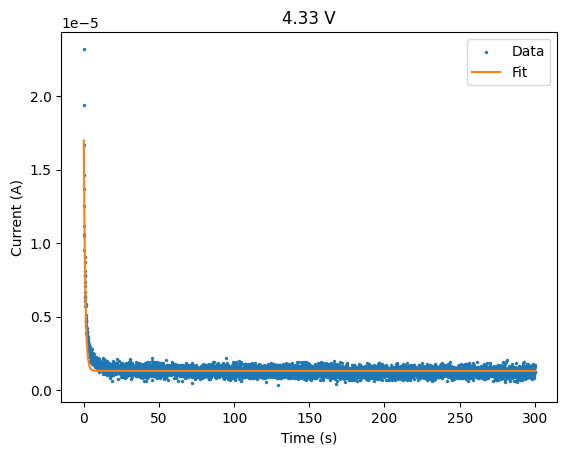

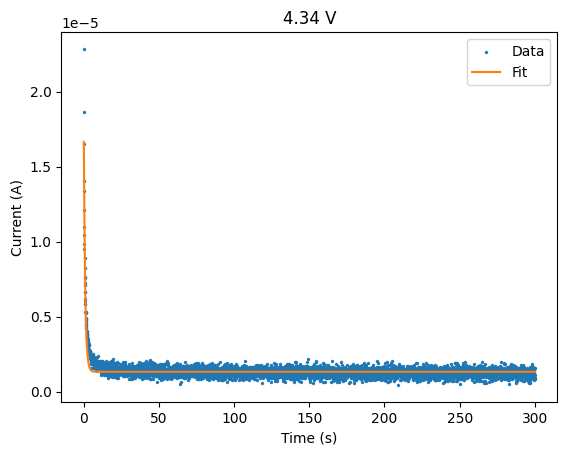

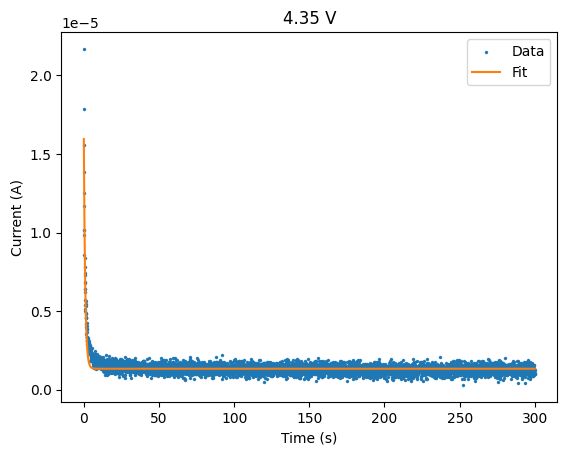

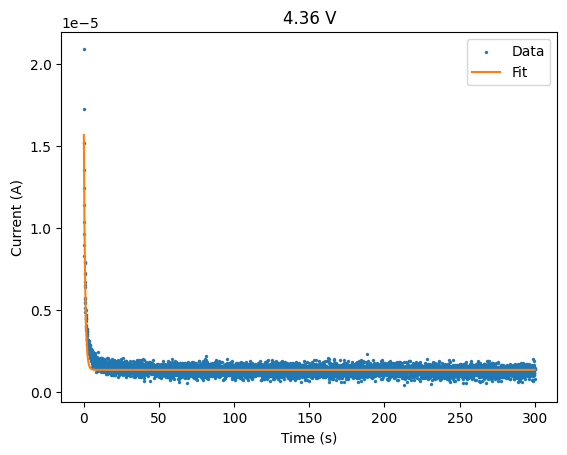

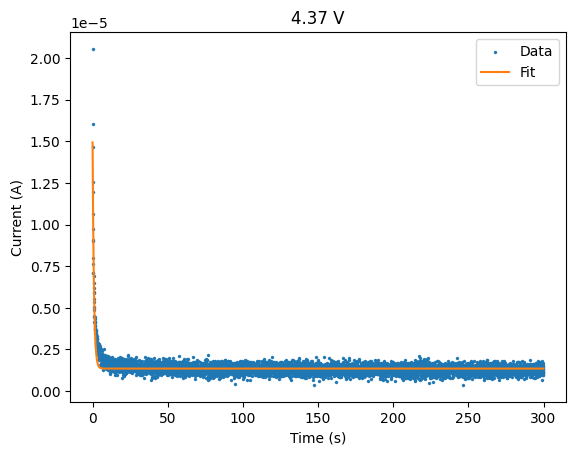

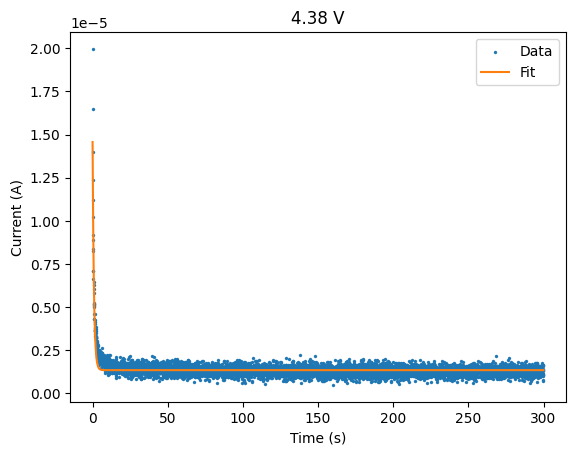

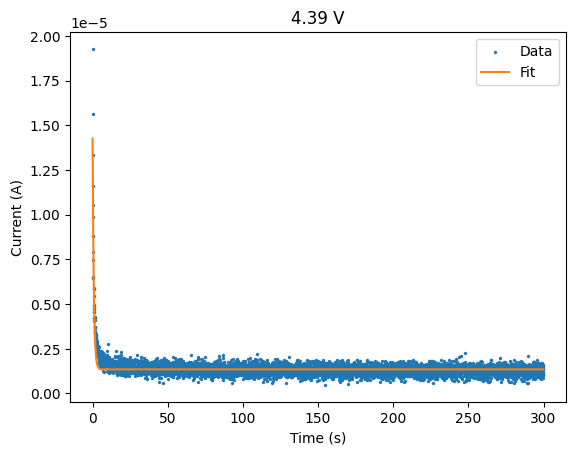

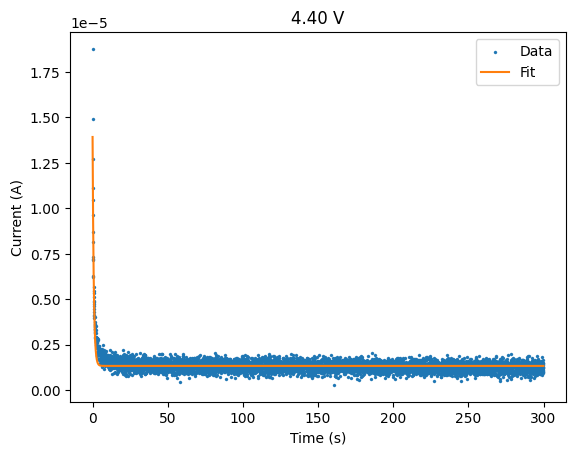

In [35]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\PLSA Pt\01\PITT_10mV'
files = [os.path.join(path, i) for i in os.listdir(path)]
area = np.pi * 0.5**2
F = 96485 # C/mol
L = 80e-7
#delta_q = F*area*L(Cs-Co)
col = ['Time', 'Time (s)', 'Current (A)', 'Potential vs Li/Li$^+$ (V)'] # 'Current Density (µA/cm$^2$)'
col2 = ['Potential vs Li/Li$^+$', 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co']

#Model
def pitt(t, delta_q, D, i_b): #t, S, C, D, L ):
    # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
    return (2 * delta_q * D / (L ** 2)) * np.exp(-((np.pi ** 2) * D * t / (4 * (L** 2)))) + i_b
gmodel = Model(pitt)
params = gmodel.make_params() 
params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
# params['L'].set(value = 80e-7, vary = False)
params['delta_q'].set(value = 0.1, min = 1e-22)
params['i_b'].set(value = 3e-7, min = 0)

data = pd.DataFrame()
fit_vals = pd.DataFrame(columns = col2)

n = 0
for i in files:
    df = pd.read_csv(i, sep = ';', skiprows = 1, names = col,  engine = 'python') #4000 skipfooter=1,
    fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
    # print(i[-12:-4])
    # print('D = ' + str(fit.values['D']))
    # print('delta_q = ' + str(fit.values['delta_q']))
    # print(fit.values['i_b'])
    
    data = pd.concat([data, df], ignore_index = True)
    fit_vals.loc[n] = (float(i[-8:-4]), fit.values['D'], fit.values['delta_q'], fit.values['delta_q']/(F * area * L))
    n += 1
    # Plot
    fig, ax = plt.subplots(dpi = 100)
    sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 5, label = 'Data')
    plt.plot(df[col[1]], fit.best_fit, color = 'tab:orange', label = 'Fit')
    plt.title(i[-8:-4] + ' V')
    plt.legend()
    
# sns.scatterplot(data = fit_vals, x = col2[0], y = col2[1])
# plt.yscale('log')
# plt.ylim(1e-12, 1e-9)


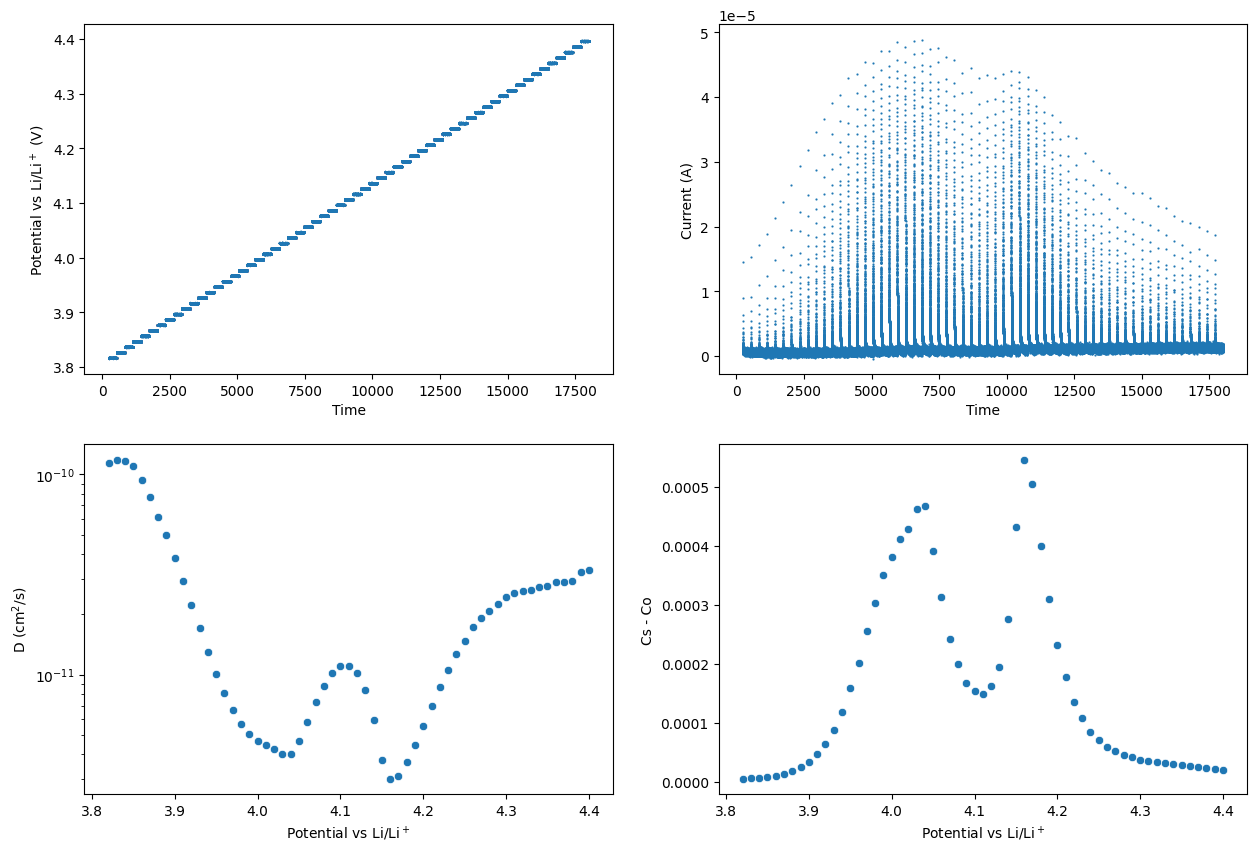

In [36]:
fig, ax = plt.subplots(2,2, dpi = 100, figsize = (15,10))
sns.scatterplot(data = data, x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
sns.scatterplot(data = data, x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
sns.scatterplot(data = fit_vals, x = col2[0], y = col2[1], ax = ax[1,0])
sns.scatterplot(data = fit_vals, x = col2[0], y = col2[3])

ax[1,0].set_yscale('log')